model 3 is our final model 

Our goal is long term investment

We can see although both the rmse and the train validation loss are high, the model is still able to predict the trend of the stock price. This is because the model is able to predict the stock price of the next day near to the current day price. This is not useful in real life.

 need to scale the features in your data before applying PCA

In [328]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import datetime
from pandas_datareader import data as pdr
import seaborn as sns

In [325]:
tech_list = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'GOOG'] #^GSPC is the S&P 500

end = datetime(2024, 8, 7, 11, 21, 24, 633194)
start = datetime(end.year - 1, end.month, end.day)

# Downloading data for each stock and storing it in a dictionary
stock_data = {}
for stock in tech_list:
    stock_data[stock] = yf.download(stock, start, end)


for stock in stock_data:
    stock_data[stock].rename(columns={"Adj Close": "Adjusted Close"}, inplace=True)

# Assigning each DataFrame to a variable for convenience
SP500 = stock_data['^GSPC']
AAPL = stock_data['AAPL']
MSFT = stock_data['MSFT']
AMZN = stock_data['AMZN']
NVDA = stock_data['NVDA']
GOOGL = stock_data['GOOGL']
TSLA = stock_data['TSLA']
GOOG = stock_data['GOOG']

# Adding company_name to each DataFrame and concatenating them
company_list = [SP500, AAPL, MSFT, AMZN, NVDA, GOOGL, TSLA, GOOG]
company_name = ["SP500", "APPLE", "MICROSOFT", "AMAZON", "NVIDIA", "GOOGLE", "TESLA", "ALPHABET"]

for df, com_name in zip(company_list, company_name):
    df["company_name"] = com_name

# Concatenating all DataFrames
df = pd.concat(company_list, axis=0)

print(df['company_name'].unique())
print(df.tail(10))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

['SP500' 'APPLE' 'MICROSOFT' 'AMAZON' 'NVIDIA' 'GOOGLE' 'TESLA' 'ALPHABET']
                  Open        High         Low       Close  Adjusted Close  \
Date                                                                         
2024-07-25  174.250000  175.199997  169.050003  169.160004      169.160004   
2024-07-26  168.770004  169.839996  165.865005  168.679993      168.679993   
2024-07-29  170.500000  172.160004  169.720001  171.130005      171.130005   
2024-07-30  171.830002  172.949997  170.119995  171.860001      171.860001   
2024-07-31  174.919998  175.910004  171.720001  173.149994      173.149994   
2024-08-01  171.979996  175.679993  170.509995  172.449997      172.449997   
2024-08-02  168.190002  170.210007  166.389999  168.399994      168.399994   
2024-08-05  157.369995  165.940002  156.600006  160.639999      160.639999   
2024-08-06  160.945007  162.350006  158.130005  160.539993      160.539993   
2024-08-07  163.240005  164.789993  160.240005  160.750000      16

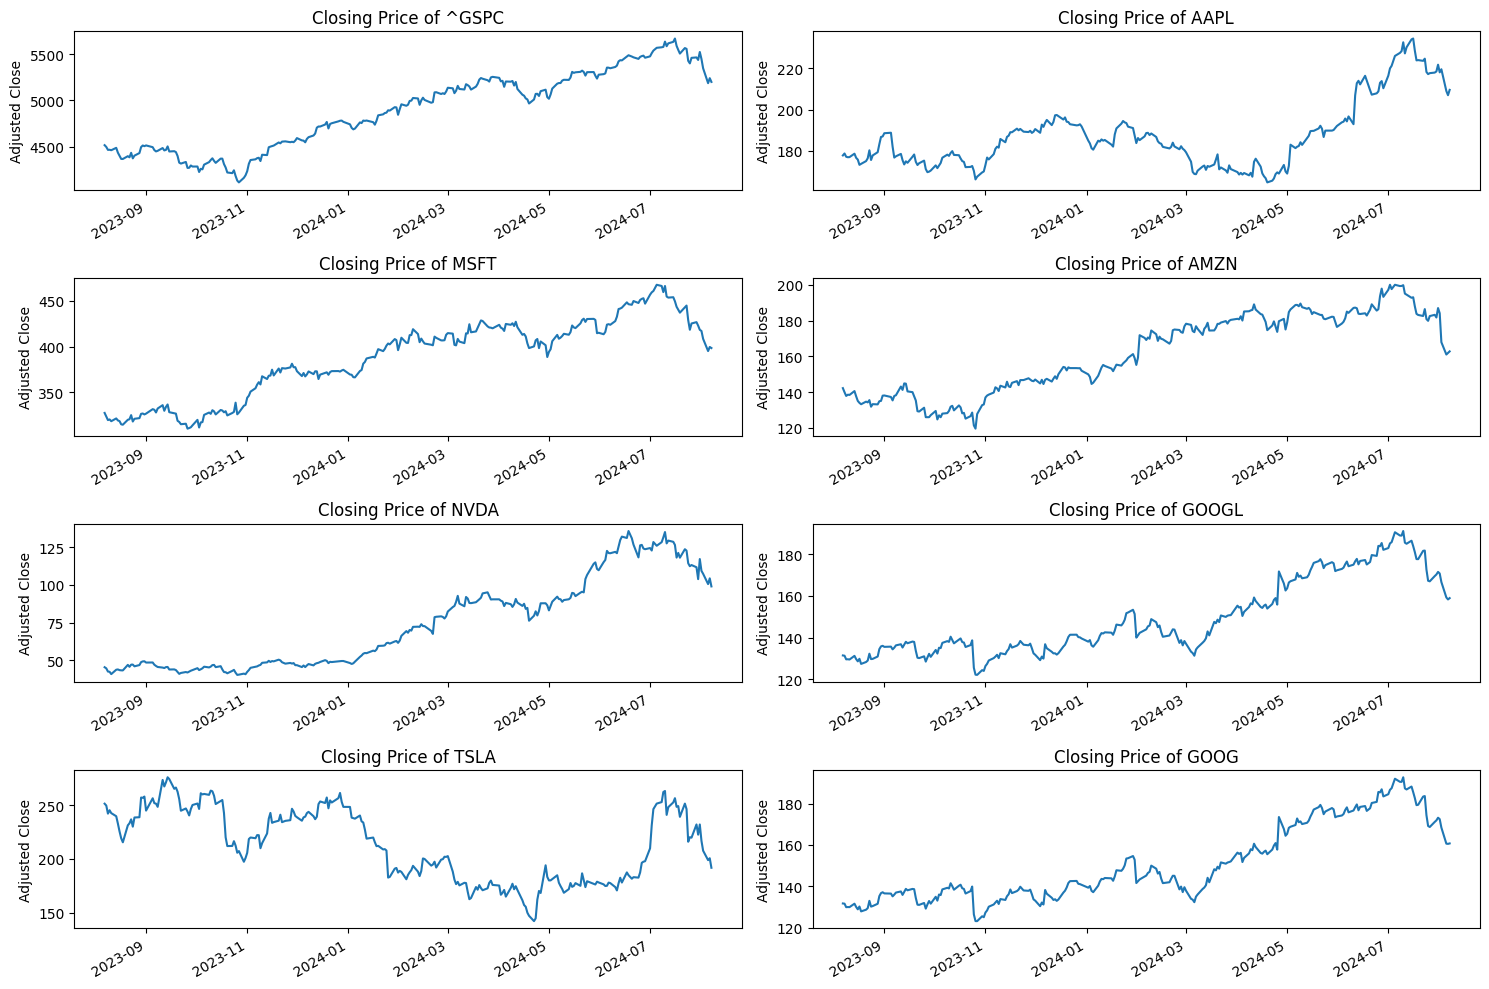

In [326]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(4, 2, i)
    company['Adjusted Close'].plot()
    plt.ylabel('Adjusted Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

All three stocks (Apple, Microsoft, Amazon) and the S&P 500 index display a general upward trend from around November 2023 to June 2024.

Each of the stocks, along with the S&P 500, reached their respective peaks around July 2024.

After peaking, all three stocks and the S&P 500 index experienced a notable decline.

Notice: Microsoft has the most similar trend to the S&P 500 index.

[*********************100%%**********************]  8 of 8 completed


Text(0.5, 1.0, 'Correlation of stock closing price')

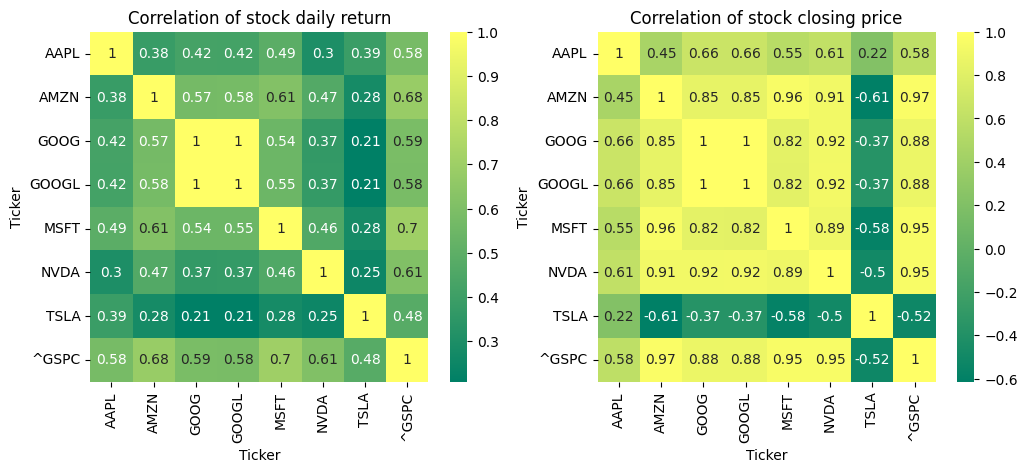

In [329]:
# Fetch the adjusted closing prices for the tech stocks
tickers = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA', 'GOOG', '^GSPC']
closing_df = yf.download(tickers, start=start, end=end)['Adj Close']
tech_rets = closing_df.pct_change()


plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock daily return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

We can see that our target is correlated with the daily return of these stock. 

In [331]:
end = datetime(2024, 8, 7, 11, 21, 24, 633194)
start = '2000-01-01'

# Fetch daily S&P 500 data
sp500_data = yf.download('^GSPC', start=start, end=end)


# Add technical indicators
sp500_data['Rsi'] = ta.rsi(sp500_data['Adj Close'], length=14)  
sp500_data['Ema_fast'] = ta.ema(sp500_data['Adj Close'], length=12)  
sp500_data['Ema_medium'] = ta.ema(sp500_data['Adj Close'], length=26)  
sp500_data['Ema_slow'] = ta.ema(sp500_data['Adj Close'], length=50) 
sp500_data['Sma_30'] = ta.sma(sp500_data['Adj Close'], length=30)  
sp500_data['Sma_100'] = ta.sma(sp500_data['Adj Close'], length=100)  

sp500_data['Bollinger_High'] = ta.bbands(sp500_data['Adj Close'], length=20, std=2)['BBU_20_2.0']
sp500_data['Bollinger_Low'] = ta.bbands(sp500_data['Adj Close'], length=20, std=2)['BBL_20_2.0']

sp500_data['ATR'] = ta.atr(sp500_data['High'], sp500_data['Low'], sp500_data['Adj Close'], length=14)
sp500_data['MACD'] = ta.macd(sp500_data['Adj Close'], fast=12, slow=26, signal=9)['MACD_12_26_9']

print(sp500_data.head())

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-01-03  1469.250000  1478.000000  1438.359985  1455.219971  1455.219971   
2000-01-04  1455.219971  1455.219971  1397.430054  1399.420044  1399.420044   
2000-01-05  1399.420044  1413.270020  1377.680054  1402.109985  1402.109985   
2000-01-06  1402.109985  1411.900024  1392.099976  1403.449951  1403.449951   
2000-01-07  1403.449951  1441.469971  1400.729980  1441.469971  1441.469971   

                Volume  Rsi  Ema_fast  Ema_medium  Ema_slow  Sma_30  Sma_100  \
Date                                                                           
2000-01-03   931800000  NaN       NaN         NaN       NaN     NaN      NaN   
2000-01-04  1009000000  NaN       NaN         NaN       NaN     NaN      NaN   
2000-01-05  1085500000  NaN       NaN         NaN       NaN     NaN      NaN   
2000-01-06  1092300000  NaN       NaN         

In [285]:
import pandas as pd
import yfinance as yf
from datetime import datetime

end = end
start = '2000-01-01'

# Fetch adjusted close prices for Apple, Amazon, and Microsoft...
tickers = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA', 'GOOG' ]
data = {}

for ticker in tickers:
    stock_data = yf.download(ticker, start=start, end=end)
    adj_close = stock_data['Adj Close']
    data[ticker] = adj_close.rename(ticker)

# Merge the data into a single DataFrame
merged_data = pd.concat(data.values(), axis=1)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [286]:
merged_data.dropna(inplace=True)

for column in merged_data.columns:
    merged_data[f'{column} DR'] = merged_data[column].pct_change()

merged_data.dropna(inplace=True)

print(merged_data.head())


                AAPL    AMZN       MSFT      NVDA      GOOGL      TSLA  \
Date                                                                     
2010-06-30  7.586102  5.4630  17.549164  0.234122  11.122120  1.588667   
2010-07-01  7.494115  5.5480  17.663567  0.238020  10.985640  1.464000   
2010-07-02  7.447670  5.4570  17.747461  0.235039  10.912151  1.280000   
2010-07-06  7.498639  5.5030  18.166929  0.232517  10.900153  1.074000   
2010-07-07  7.801443  5.6715  18.533022  0.243753  11.253350  1.053333   

                 GOOG   AAPL DR   AMZN DR   MSFT DR   NVDA DR  GOOGL DR  \
Date                                                                      
2010-06-30  11.069613 -0.018113  0.005985 -0.012870 -0.025763 -0.020495   
2010-07-01  10.933779 -0.012126  0.015559  0.006519  0.016650 -0.012271   
2010-07-02  10.860637 -0.006198 -0.016402  0.004750 -0.012524 -0.006689   
2010-07-06  10.848695  0.006844  0.008430  0.023635 -0.010732 -0.001100   
2010-07-07  11.200226  0.040381

In [287]:

columns_to_drop = ['AAPL', 'AMZN', 'MSFT', 'NVDA', 'GOOGL', 'TSLA',  'GOOG']
data = {}

merged_data.drop(columns=columns_to_drop, inplace=True)

print(merged_data.head())

             AAPL DR   AMZN DR   MSFT DR   NVDA DR  GOOGL DR   TSLA DR  \
Date                                                                     
2010-06-30 -0.018113  0.005985 -0.012870 -0.025763 -0.020495 -0.002511   
2010-07-01 -0.012126  0.015559  0.006519  0.016650 -0.012271 -0.078473   
2010-07-02 -0.006198 -0.016402  0.004750 -0.012524 -0.006689 -0.125683   
2010-07-06  0.006844  0.008430  0.023635 -0.010732 -0.001100 -0.160937   
2010-07-07  0.040381  0.030620  0.020152  0.048323  0.032403 -0.019243   

             GOOG DR  
Date                  
2010-06-30 -0.020495  
2010-07-01 -0.012271  
2010-07-02 -0.006690  
2010-07-06 -0.001100  
2010-07-07  0.032403  


In [288]:
merged_data = pd.concat([sp500_data, merged_data], axis=1).dropna()

print(merged_data.shape)
print(merged_data.columns)

(3550, 23)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Rsi',
       'Ema_fast', 'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100',
       'Bollinger_High', 'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR',
       'MSFT DR', 'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR'],
      dtype='object')


let's add some economic features to the dataset 

In [289]:
# Fetch economic data
gdp = pdr.get_data_fred('GDP', start=start, end=end) #quaterly
inflation = pdr.get_data_fred('CPIAUCSL', start=start, end=end)  # CPI for inflation
unemployment = pdr.get_data_fred('UNRATE', start=start, end=end)
interest_rate = pdr.get_data_fred('FEDFUNDS', start=start, end=end)

# Rename columns for clarity
gdp.rename(columns={'GDP': 'GDP'}, inplace=True)
inflation.rename(columns={'CPIAUCSL': 'Inflation'}, inplace=True)
unemployment.rename(columns={'UNRATE': 'Unemployment'}, inplace=True)
interest_rate.rename(columns={'FEDFUNDS': 'Interest_Rate'}, inplace=True)
GDP = gdp.resample('D').ffill()
Inflation = inflation.resample('D').ffill()
Unemployment = unemployment.resample('D').ffill()
Interest_rate = interest_rate.resample('D').ffill()

merged_data = merged_data.join([Inflation, Unemployment, Interest_rate, GDP], how='left')

print(merged_data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Rsi',
       'Ema_fast', 'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100',
       'Bollinger_High', 'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR',
       'MSFT DR', 'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR', 'Inflation',
       'Unemployment', 'Interest_Rate', 'GDP'],
      dtype='object')


In [290]:
n_lags = 3
for col in ['Adj Close', 'Rsi', 'MACD']:
    for lag in range(1, n_lags + 1):
        merged_data[f'{col}_lag_{lag}'] = merged_data[col].shift(lag)



merged_data['Target'] = merged_data['Adj Close'].pct_change()

merged_data.dropna(inplace=True)
merged_data.reset_index(inplace = True)
Date = merged_data['Date']
merged_data.drop([ 'Date', 'Volume'], axis=1, inplace=True)
print(merged_data.head())

          Open         High          Low        Close    Adj Close        Rsi  \
0  1028.089966  1042.500000  1018.349976  1028.060059  1028.060059  32.767748   
1  1028.540039  1060.890015  1028.540039  1060.270020  1060.270020  45.156109   
2  1062.920044  1071.250000  1058.239990  1070.250000  1070.250000  48.332802   
3  1070.500000  1078.160034  1068.099976  1077.959961  1077.959961  50.708161   
4  1077.229980  1080.780029  1070.449951  1078.750000  1078.750000  50.956973   

      Ema_fast   Ema_medium     Ema_slow       Sma_30  ...  Adj Close_lag_1  \
0  1055.252067  1076.029172  1097.563245  1077.334996  ...      1022.580017   
1  1056.024059  1074.861827  1096.100766  1076.888995  ...      1028.060059   
2  1058.212666  1074.520210  1095.087010  1076.762994  ...      1060.270020   
3  1061.250711  1074.775007  1094.415361  1077.096661  ...      1070.250000   
4  1063.942909  1075.069450  1093.801033  1076.286326  ...      1077.959961   

   Adj Close_lag_2  Adj Close_lag_3  R

In [332]:
#sekect some columns
dd = merged_data[['Inflation', 'Unemployment', 'Interest_Rate', 'GDP', 'Target', 'Adj Close']]


import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(dd.corr(), annot=True, cmap='coolwarm')

KeyError: "['Inflation', 'Unemployment', 'Interest_Rate', 'GDP'] not in index"

not include the econocy indicators 

In [293]:
#drop 'Inflation', 'Unemployment', 'Interest_Rate', 'GDP',
merged_data.drop(['Inflation', 'Unemployment', 'Interest_Rate', 'GDP'], axis=1, inplace=True)
print(merged_data.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Rsi', 'Ema_fast',
       'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100', 'Bollinger_High',
       'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR', 'MSFT DR',
       'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR', 'Adj Close_lag_1',
       'Adj Close_lag_2', 'Adj Close_lag_3', 'Rsi_lag_1', 'Rsi_lag_2',
       'Rsi_lag_3', 'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3', 'Target'],
      dtype='object')


In [294]:

features= merged_data.drop(['Target'], axis=1)
print(features.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Rsi', 'Ema_fast',
       'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100', 'Bollinger_High',
       'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR', 'MSFT DR',
       'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR', 'Adj Close_lag_1',
       'Adj Close_lag_2', 'Adj Close_lag_3', 'Rsi_lag_1', 'Rsi_lag_2',
       'Rsi_lag_3', 'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3'],
      dtype='object')


 need to scale the features in your data before applying PCA

In [295]:
features = features.columns
print(features)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Rsi', 'Ema_fast',
       'Ema_medium', 'Ema_slow', 'Sma_30', 'Sma_100', 'Bollinger_High',
       'Bollinger_Low', 'ATR', 'MACD', 'AAPL DR', 'AMZN DR', 'MSFT DR',
       'NVDA DR', 'GOOGL DR', 'TSLA DR', 'GOOG DR', 'Adj Close_lag_1',
       'Adj Close_lag_2', 'Adj Close_lag_3', 'Rsi_lag_1', 'Rsi_lag_2',
       'Rsi_lag_3', 'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3'],
      dtype='object')


In [296]:
from sklearn.preprocessing import StandardScaler
x = merged_data.loc[:, features].values
y = merged_data.loc[:,['Target']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [297]:
pd.DataFrame(data = x, columns = features).head()

,Open,High,Low,Close,Adj Close,Rsi,Ema_fast,Ema_medium,Ema_slow,Sma_30,...,GOOG DR,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,Rsi_lag_1,Rsi_lag_2,Rsi_lag_3,MACD_lag_1,MACD_lag_2,MACD_lag_3
0,-1.465795,-1.457302,-1.469557,-1.466121,-1.466121,-2.043697,-1.440759,-1.420562,-1.397795,-1.418138,...,-0.117281,-1.470775,-1.466040,-1.462631,-2.263661,-2.177838,-2.118851,-0.904396,-0.830440,-0.743801
1,-1.465383,-1.440568,-1.460177,-1.436651,-1.436651,-0.936758,-1.440050,-1.421639,-1.399153,-1.418550,...,1.829241,-1.465758,-1.470427,-1.465691,-2.041491,-2.261520,-2.175825,-0.940429,-0.903940,-0.830003
2,-1.433921,-1.431142,-1.432837,-1.427521,-1.427521,-0.652911,-1.438040,-1.421954,-1.400095,-1.418667,...,0.767393,-1.436273,-1.465408,-1.470081,-0.935262,-2.039470,-2.259464,-0.877273,-0.939983,-0.903525
3,-1.426985,-1.424854,-1.423761,-1.420466,-1.420466,-0.440665,-1.435250,-1.421719,-1.400719,-1.418359,...,1.337526,-1.427138,-1.435908,-1.465059,-0.651597,-0.933836,-2.037528,-0.794874,-0.876810,-0.939579
4,-1.420826,-1.422470,-1.421598,-1.419744,-1.419744,-0.418433,-1.432777,-1.421447,-1.401289,-1.419107,...,0.983115,-1.420080,-1.426768,-1.435543,-0.439487,-0.650324,-0.932464,-0.704236,-0.794388,-0.876387


In [298]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=10)  
principalComponents = pca.fit_transform(x)
pca.explained_variance_ratio_

array([0.50168872, 0.210863  , 0.13721485, 0.03722736, 0.02710949,
       0.02002892, 0.01626361, 0.01586561, 0.0117978 , 0.0095271 ])

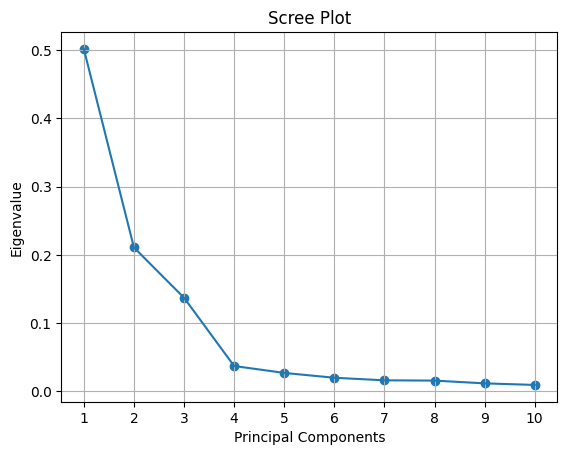

In [299]:
# Explained variance ratio
importance = pca.explained_variance_ratio_

# Scree plot
plt.scatter(range(1, len(importance) + 1), importance)
plt.plot(range(1, len(importance) + 1), importance)
plt.title('Scree Plot')
plt.xlabel('Principal Components')  
plt.ylabel('Eigenvalue')  
plt.xticks(range(1, len(importance) + 1))
plt.grid(True)
plt.show()

In [300]:
pca = PCA(n_components=3) 
principalComponents = pca.fit_transform(x)
print(sum(pca.explained_variance_ratio_))

0.84976657986969


by look at the ratio and the plot, 3 principal components can explain 84% of the variance in the data.

In [301]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])
finalDf = pd.concat([principalDf, merged_data[['Target']]], axis = 1)

finalDf.head(5)

,PC1,PC2,PC3,Target
0,-5.860558,-3.712899,-0.656254,0.005359
1,-5.841506,-3.204735,3.893143,0.031331
2,-5.802316,-2.723477,1.545879,0.009413
3,-5.729781,-2.043894,1.300511,0.007204
4,-5.669946,-1.385848,1.581695,0.000733


In [302]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df_cm = pd.DataFrame(np.abs(pca.components_), columns=merged_data.columns[:-1])
plt.figure(figsize=(18, 10))  # Increase figure size further
ax = sns.heatmap(df_cm, annot=True, cmap="coolwarm", linewidths=0.5, linecolor='black', vmin=0, vmax=1, annot_kws={"size": 10})
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15, rotation=45)  # Rotate x labels for better fit
plt.title('PCA Component Loadings', fontsize=24)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('factorAnalysis_improved.png', dpi=300)  # Save the high-quality image
plt.show()  # Display the plot


we can see...

In [303]:
print(finalDf.head(5))
print(finalDf.shape)

        PC1       PC2       PC3    Target
0 -5.860558 -3.712899 -0.656254  0.005359
1 -5.841506 -3.204735  3.893143  0.031331
2 -5.802316 -2.723477  1.545879  0.009413
3 -5.729781 -2.043894  1.300511  0.007204
4 -5.669946 -1.385848  1.581695  0.000733
(3458, 4)


let's now perform LSTM on the data and see how it performs.

standardizes only the feature columns (excluding the target column).
excludes the target column when preparing sequences for LSTM, ensuring that the LSTM inputs consist solely of features.
avoid data leaking 

In [306]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

splitlimit = int(finalDf.shape[0] * 0.8)
trainDf, testDf = finalDf[:splitlimit], finalDf[splitlimit:]

# Standardize the data excluding the target column 
sc = StandardScaler()
trainDf_scaled = sc.fit_transform(trainDf.iloc[:, :-1])#exclude the target column
testDf_scaled = sc.transform(testDf.iloc[:, :-1])

# Prepare the sequences for LSTM
backcandles = 30


X_train = []
X_test = []

for j in range(trainDf_scaled.shape[1]):  # loop over features
    temp_train = []
    for i in range(backcandles, len(trainDf_scaled)):
        temp_train.append(trainDf_scaled[i-backcandles:i, j])
    X_train.append(temp_train)


for j in range(testDf_scaled.shape[1]):  # loop over features
    temp_test = []
    for i in range(backcandles, len(testDf_scaled)):
        temp_test.append(testDf_scaled[i-backcandles:i, j])
    X_test.append(temp_test)

# Convert lists to numpy arrays and move axes
X_train = np.moveaxis(np.array(X_train), 0, 2)
X_test = np.moveaxis(np.array(X_test), 0, 2)

# Extract target variables assuming target is in the last column
y_train = np.array(trainDf.iloc[backcandles:, -1])
y_test = np.array(testDf.iloc[backcandles:, -1])

# Reshape targets to (samples, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Output shapes for verification
print("Training Data Shape:", X_train.shape)
print("Training Target Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)
print("Test Target Shape:", y_test.shape)


Training Data Shape: (2736, 30, 3)
Training Target Shape: (2736, 1)
Test Data Shape: (662, 30, 3)
Test Target Shape: (662, 1)


/Users/qianqianmeng/.virtualenvs/r-reticulate/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.0048 - mean_absolute_error: 0.0531 - root_mean_squared_error: 0.0690 - val_loss: 8.3981e-04 - val_mean_absolute_error: 0.0214 - val_root_mean_squared_error: 0.0290 - learning_rate: 1.0000e-04
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0016 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0401 - val_loss: 5.3269e-04 - val_mean_absolute_error: 0.0152 - val_root_mean_squared_error: 0.0231 - learning_rate: 1.0000e-04
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0015 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0385 - val_loss: 4.7224e-04 - val_mean_absolute_error: 0.0140 - val_root_mean_squared_error: 0.0217 - learning_rate: 1.0000e-04
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010 - mean_absolute_error: 0.0244 - root_mean_squared_error: 0.0321 - val_loss: 5.2072e-04 - val_mean_absolute_error: 0.0151 - val_root_mean_squared_error: 0.0228 - learning_rat

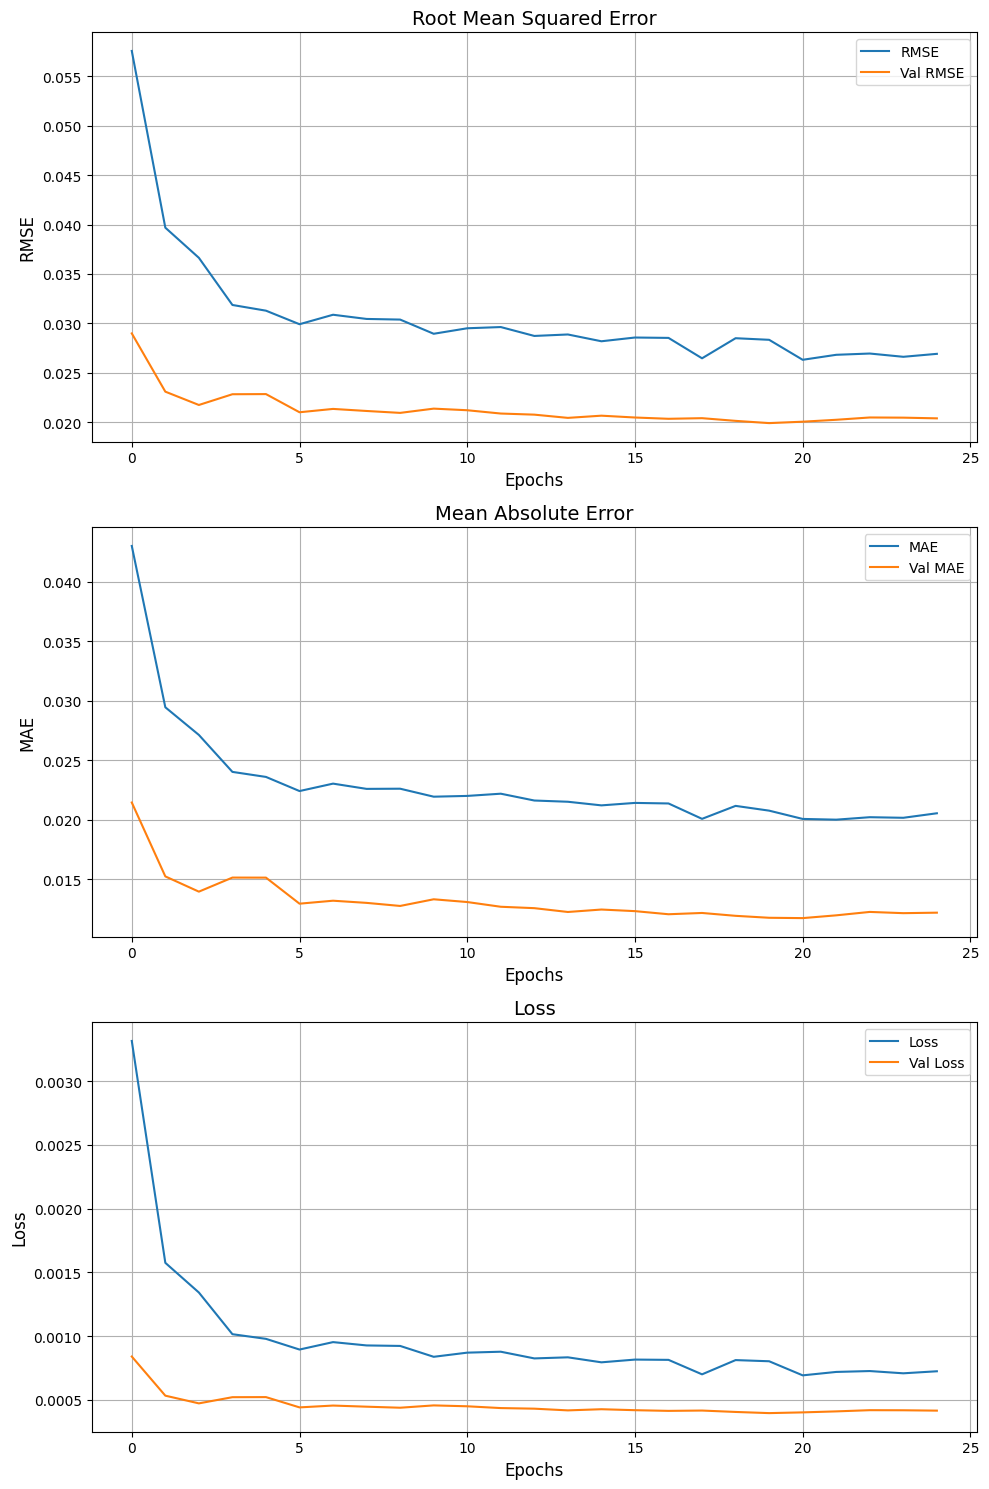

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.0091e-04 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0264
Test Loss: 0.0005748182884417474, Test RMSE: 0.023975368589162827, Test MAE: 0.019831832498311996


In [307]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

tf.random.set_seed(123)
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(1)
])



# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', 
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

# Callbacks for early stopping, model checkpointing, and learning rate reduction
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Fit the model with callbacks
history = model.fit(X_train, y_train, epochs=50, batch_size=64, 
                    validation_split=0.2,
                    callbacks=[es, model_checkpoint, reduce_lr])

# Load the best model based on validation loss
model.load_weights('best_model.keras')

# Plotting the RMSE, MAE, and Loss
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# RMSE plot
ax1.plot(history.epoch, history.history['root_mean_squared_error'], label="RMSE")
ax1.plot(history.epoch, history.history['val_root_mean_squared_error'], label="Val RMSE")
ax1.set_title("Root Mean Squared Error", fontsize=14)
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("RMSE", fontsize=12)
ax1.legend()
ax1.grid(True)

# MAE plot
ax2.plot(history.epoch, history.history['mean_absolute_error'], label="MAE")
ax2.plot(history.epoch, history.history['val_mean_absolute_error'], label="Val MAE")
ax2.set_title("Mean Absolute Error", fontsize=14)
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel("MAE", fontsize=12)
ax2.legend()
ax2.grid(True)

# Loss plot
ax3.plot(history.epoch, history.history['loss'], label="Loss")
ax3.plot(history.epoch, history.history['val_loss'], label="Val Loss")
ax3.set_title("Loss", fontsize=14)
ax3.set_xlabel("Epochs", fontsize=12)
ax3.set_ylabel("Loss", fontsize=12)
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on the test set
test_loss, test_rmse, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test RMSE: {test_rmse}, Test MAE: {test_mae}")


In [333]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[-0.0211194] [0.00414638]
[-0.01918304] [0.00160731]
[-0.01859624] [0.00262085]
[-0.01814142] [-0.0070607]
[-0.01951466] [-0.01074847]
[-0.02071905] [0.00125669]
[-0.02023507] [0.00814157]
[-0.01857934] [0.00852379]
[-0.01676757] [0.00149574]
[-0.0178755] [0.00222012]


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


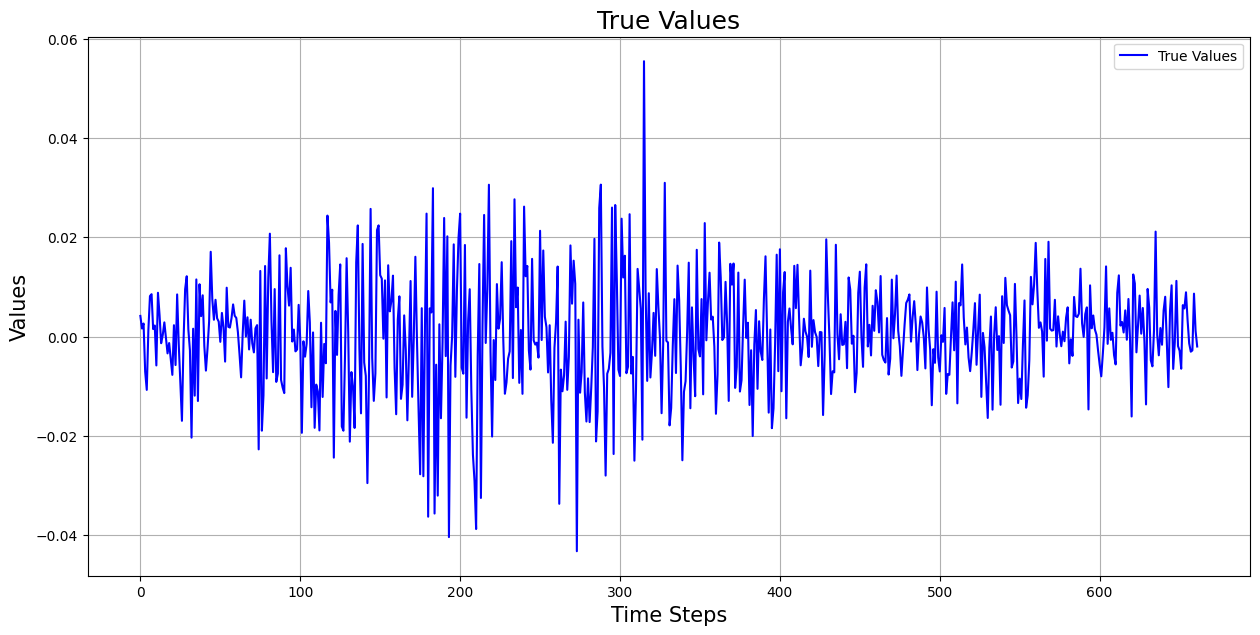

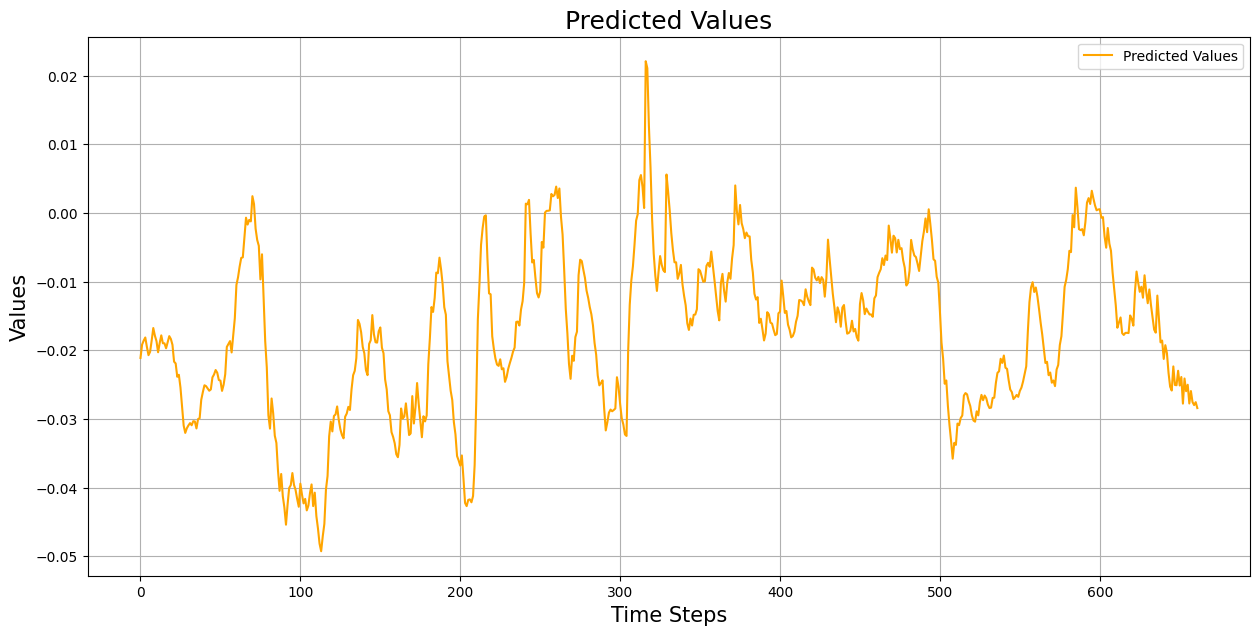

In [323]:
import matplotlib.pyplot as plt

# Generate predictions using the test set
y_pred = model.predict(X_test)

# Flatten the arrays 
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Plot True Values
plt.figure(figsize=(15, 7))
plt.plot(y_test_flat, label='True Values', color='blue')
plt.title('True Values', fontsize=18)
plt.xlabel('Time Steps', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.grid(True)
plt.legend()
plt.show()

# Plot Predicted Values
plt.figure(figsize=(15, 7))
plt.plot(y_pred_flat, label='Predicted Values', color='orange')
plt.title('Predicted Values', fontsize=18)
plt.xlabel('Time Steps', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.grid(True)
plt.legend()
plt.show()


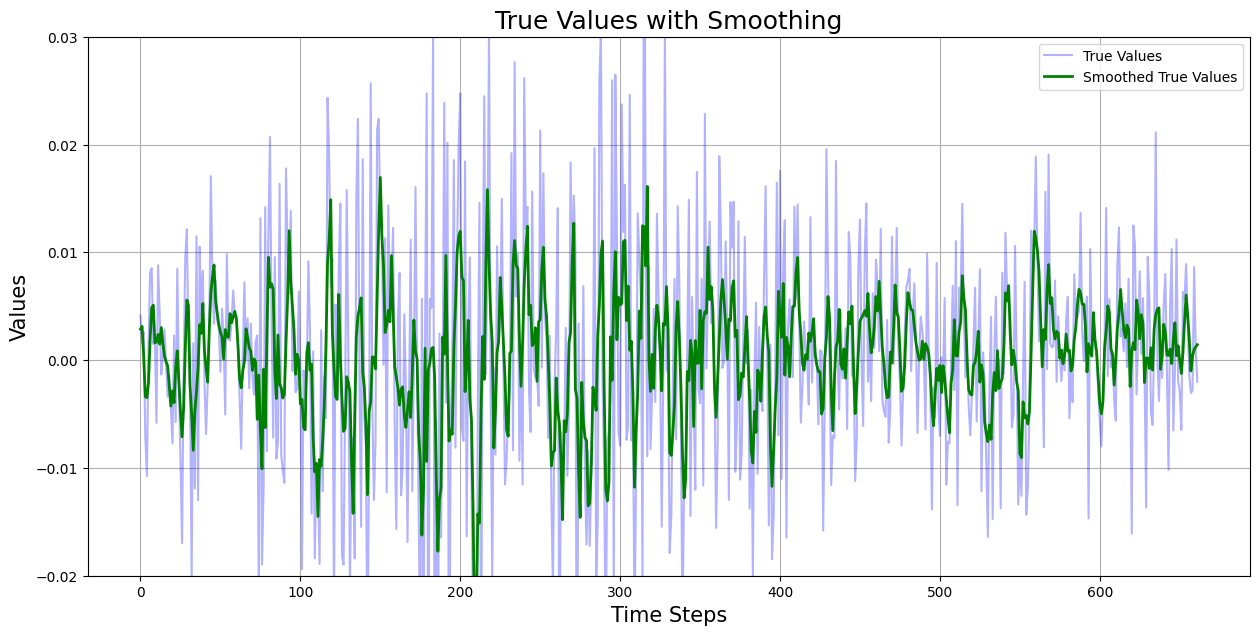

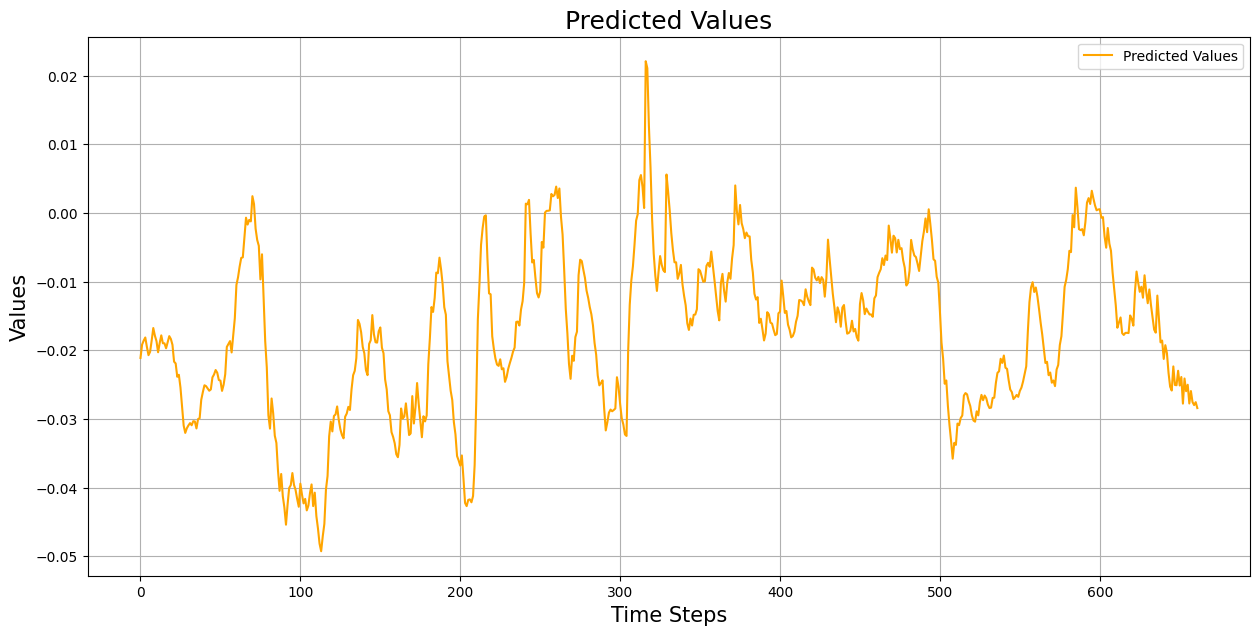

In [324]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d


# Flatten the arrays for plotting if necessary
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Smooth the true values using a moving average
window_size = 4 # You can adjust this value for more or less smoothing
y_test_smooth = uniform_filter1d(y_test_flat, size=window_size)

# Plot True Values with Smoothing
plt.figure(figsize=(15, 7))
plt.plot(y_test_flat, label='True Values', color='blue', alpha=0.3)  # Original true values
plt.plot(y_test_smooth, label='Smoothed True Values', color='green', linewidth=2)  # Smoothed true values
plt.title('True Values with Smoothing', fontsize=18)
plt.xlabel('Time Steps', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.grid(True)
plt.legend()
plt.ylim([-0.02, 0.03])
plt.show()

# Plot Predicted Values
plt.figure(figsize=(15, 7))
plt.plot(y_pred_flat, label='Predicted Values', color='orange')
plt.title('Predicted Values', fontsize=18)
plt.xlabel('Time Steps', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.grid(True)
plt.legend()
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


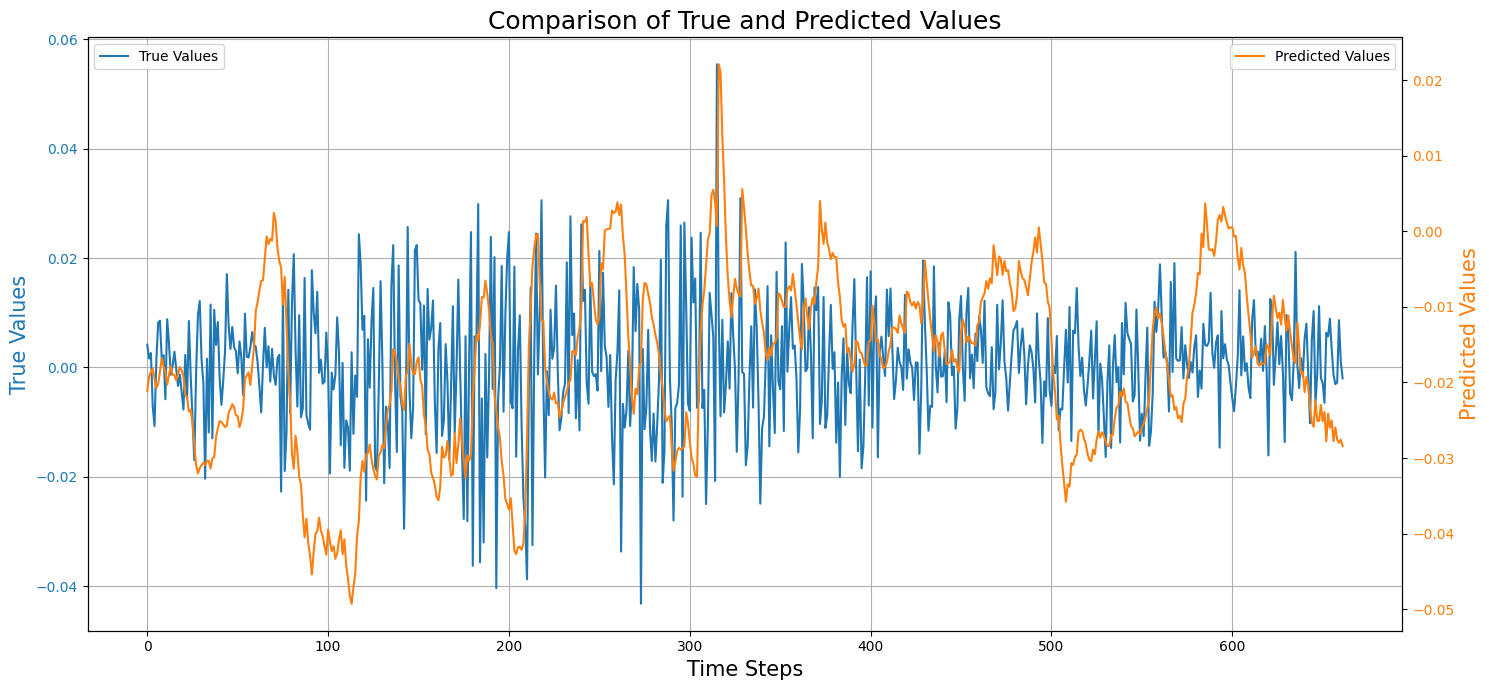

In [316]:
import matplotlib.pyplot as plt

# Generate predictions using the test set
y_pred = model.predict(X_test)

# Flatten the arrays for plotting if necessary
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot True Values on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Time Steps', fontsize=15)
ax1.set_ylabel('True Values', color=color, fontsize=15)
ax1.plot(y_test_flat, color=color, label='True Values')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a second y-axis for the predicted values
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('Predicted Values', color=color, fontsize=15)  # we already handled the x-label with ax1
ax2.plot(y_pred_flat, color=color, label='Predicted Values')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Final touches
plt.title('Comparison of True and Predicted Values', fontsize=18)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


gRIDD search 

Generalization Gap: There is still a generalization gap, but it’s more controlled now. This indicates that the model is learning, but the complexity might still be slightly high, or the data might be more challenging to generalize well.
Stabilization: Both metrics stabilize, which is a good sign that the model is not overfitting excessively.

LSTM and GRU Combination:

In [318]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", np.round(results, 4))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.0091e-04 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0264
test loss, test acc: [0.0006 0.024  0.0198]


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


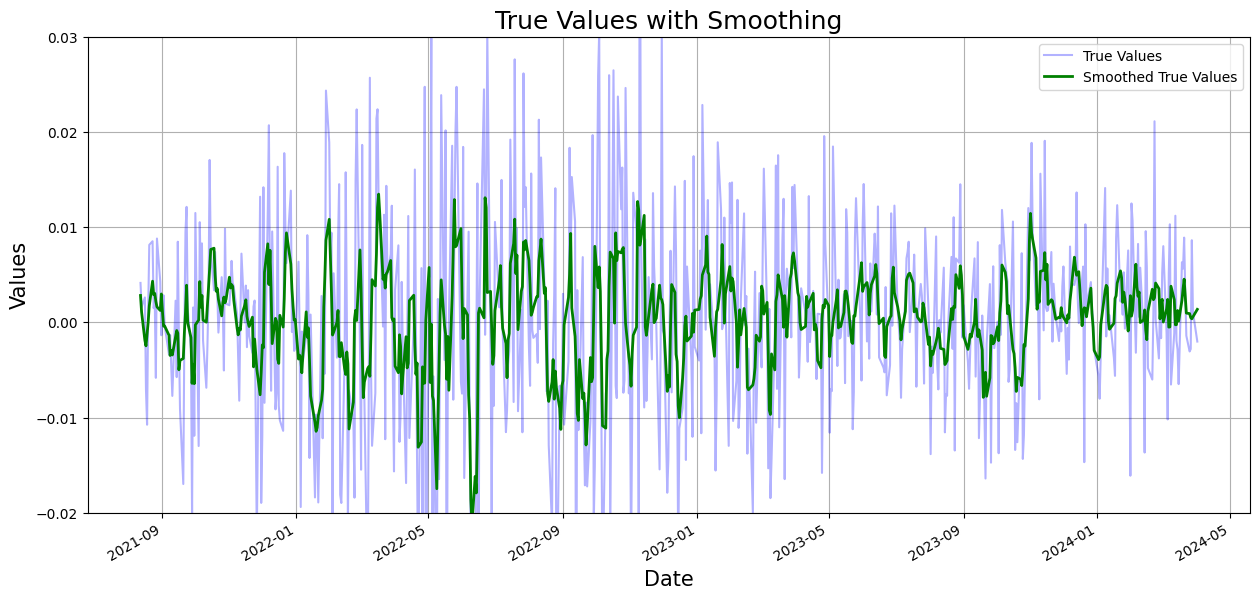

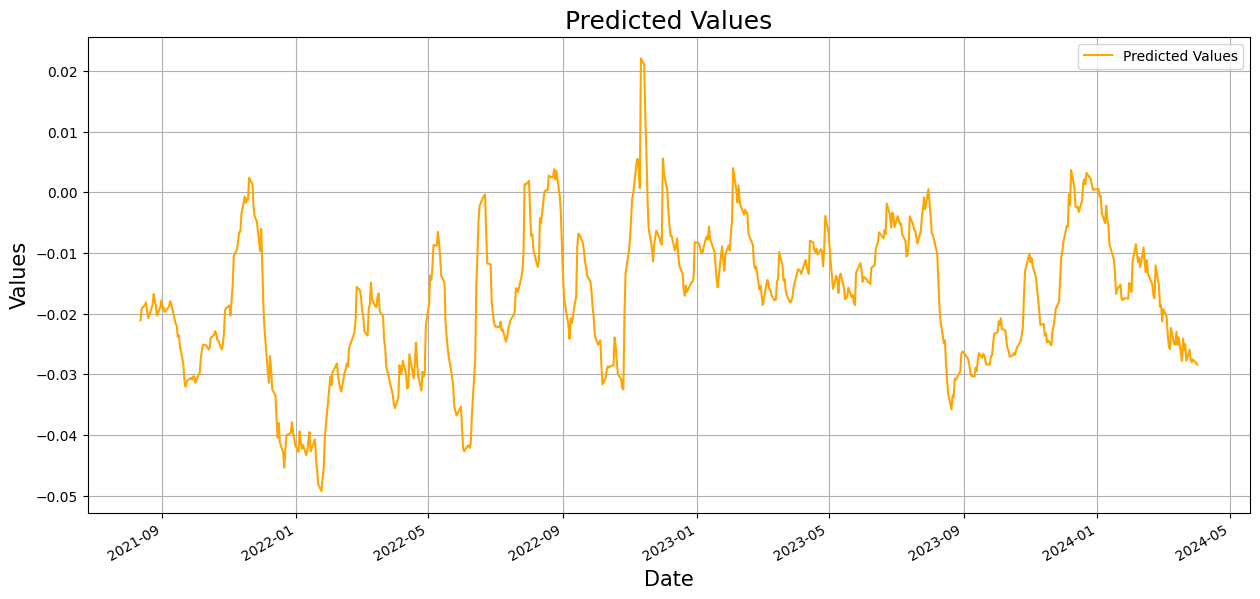

In [319]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from datetime import datetime
import pandas as pd

# Assume 'dates' is an array of datetime objects corresponding to y_test_flat and y_pred_flat
# If 'dates' is not in datetime format, you will need to convert it:
# dates = pd.to_datetime(dates)
dates = Date[splitlimit + backcandles:]  # Skip the first `backcandles` dates to align with your test data

# Generate predictions using the test set
y_pred = model.predict(X_test)

# Flatten the arrays for plotting if necessary
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Smooth the true values using a moving average
window_size = 5 # You can adjust this value for more or less smoothing
y_test_smooth = uniform_filter1d(y_test_flat, size=window_size)

# Assuming 'dates' array aligns with 'y_test_flat' and 'y_pred_flat'
# Plot True Values with Smoothing and Date on X-axis
plt.figure(figsize=(15, 7))
plt.plot(dates, y_test_flat, label='True Values', color='blue', alpha=0.3)  # Original true values
plt.plot(dates, y_test_smooth, label='Smoothed True Values', color='green', linewidth=2)  # Smoothed true values
plt.title('True Values with Smoothing', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.grid(True)
plt.legend()
plt.gcf().autofmt_xdate()  # Rotate date labels to fit them better
plt.ylim([-0.02, 0.03])
plt.show()

# Plot Predicted Values with Date on X-axis
plt.figure(figsize=(15, 7))
plt.plot(dates, y_pred_flat, label='Predicted Values', color='orange')
plt.title('Predicted Values', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Values', fontsize=15)
plt.grid(True)
plt.legend()
plt.gcf().autofmt_xdate()  # Rotate date labels to fit them better
plt.show()


In [320]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[-0.0211194] [0.00414638]
[-0.01918304] [0.00160731]
[-0.01859624] [0.00262085]
[-0.01814142] [-0.0070607]
[-0.01951466] [-0.01074847]
[-0.02071905] [0.00125669]
[-0.02023507] [0.00814157]
[-0.01857934] [0.00852379]
[-0.01676757] [0.00149574]
[-0.0178755] [0.00222012]


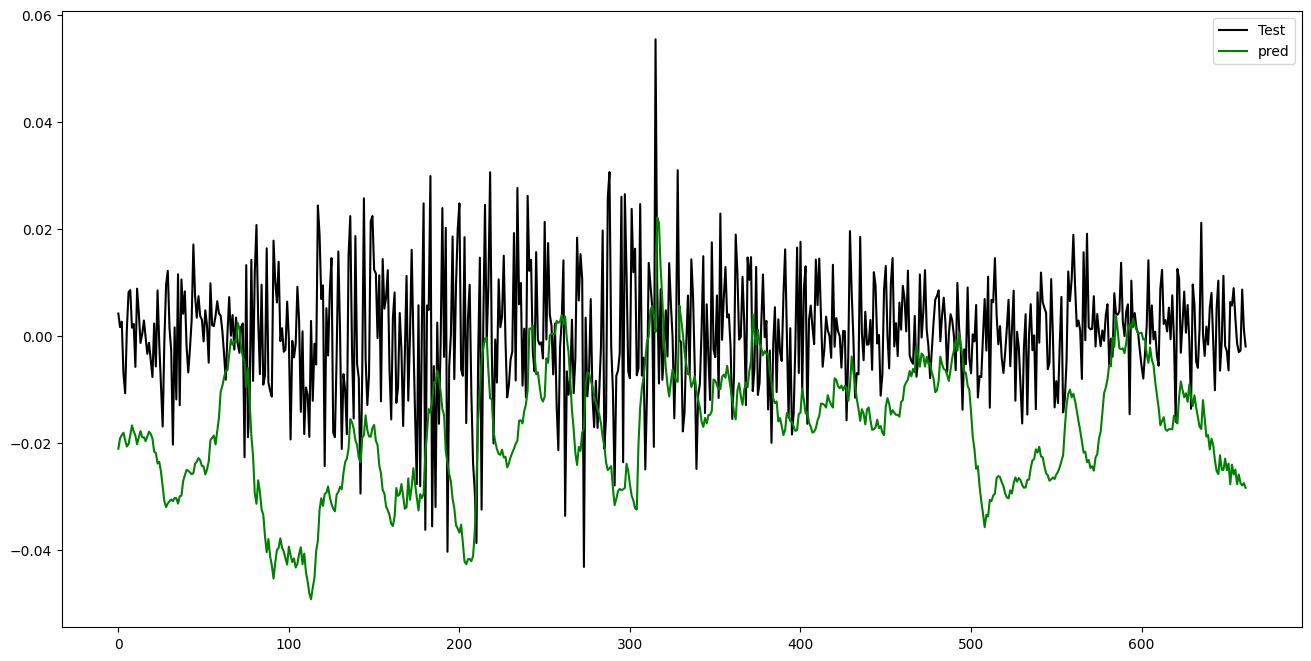

In [334]:

plt.figure(figsize=(16,8))
plt.plot(y_test_flat, color = 'black', label = 'Test')
plt.plot(y_pred_flat, color = 'green', label = 'pred')
plt.legend()
plt.show()
